In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mrmr import mrmr_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform
from sklearn.model_selection import train_test_split
from scipy.stats import randint, uniform
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
import catboost as cb
from sklearn.model_selection import cross_val_score

# Pre-processing

## Load data

In [73]:
X = pd.read_csv("../species_features.csv", sep=";")
# filter out samples with negative TG serology
y = pd.read_csv("../../labels.csv", sep=";")
y = y.loc[y["Sample"].isin(X["Sample"])].set_index("Sample", drop=True)["Label"]
X = X.set_index("Sample", drop=True)
X.shape

(121, 4630)

[Text(0, 0, 'Healthy'), Text(1, 0, 'CD')]

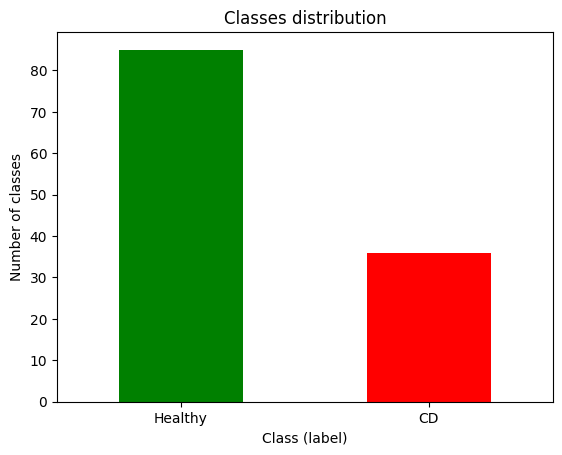

In [50]:
ax = y.value_counts().plot(
  kind='bar',
  color=["green","red"],
  title="Classes distribution",
  ylabel="Number of classes",
  xlabel="Class (label)",
  rot=0
)
ax.set_xticklabels(["Healthy", "CD"])

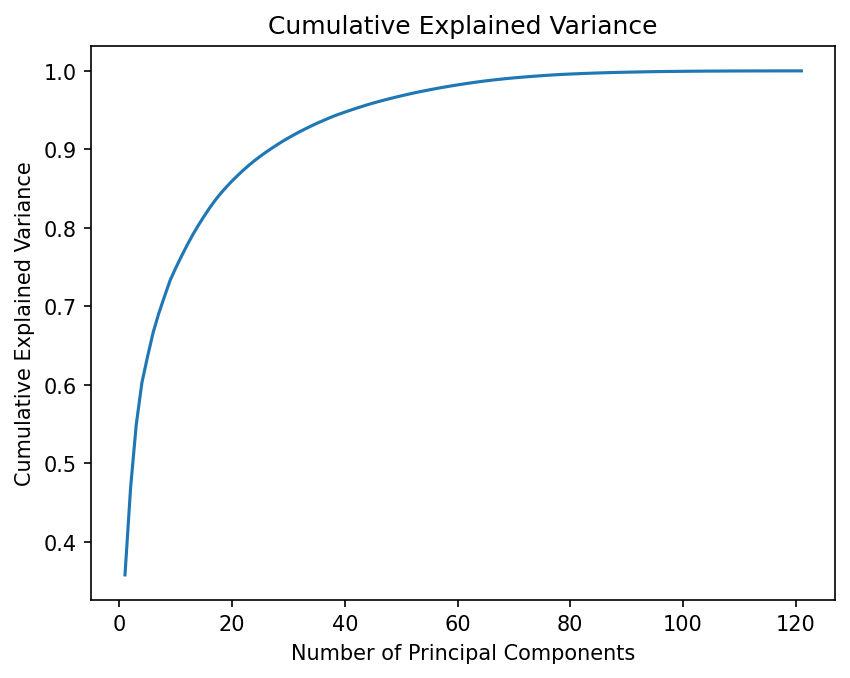

In [51]:
# Perform PCA
pca = PCA(random_state=42)
pca.fit(X)
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)
fig = plt.figure(dpi=150)
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance)
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

## Remove features with less than n% unique values

In [59]:
# Calculate the percentage of unique values for each feature
unique_percentages = (X.nunique() / X.shape[0]) * 100

# Identify features with more than 90% same values
features_to_drop = unique_percentages[unique_percentages < 95].index

# Remove the identified features from the DataFrame
filtered_X = X.drop(features_to_drop, axis=1)
filtered_X.shape

(121, 993)

## MRMR to select k features 

In [60]:
selected_features = mrmr_classif(X=filtered_X, y=y, K=30)
X[selected_features]

100%|██████████| 30/30 [00:02<00:00, 13.97it/s]


,Blautia_A sp900553515,Prevotella hominis,Veillonella parvula_A,MGYG000000711,Coprococcus eutactus,Bacteroides massiliensis_A,Slackia_A sp900553775,MGYG000004886,Collinsella aerofaciens_H,Phocaeicola sp000434735,...,Agathobaculum butyriciproducens,MGYG000004127,Acutalibacter sp900548545,Streptococcus vestibularis,Bacteroides ovatus,Blautia_A wexlerae_A,Faecalibacillus intestinalis,Eubacterium_I sp900066595,Phil1 sp001940855,Streptococcus salivarius
Sample,,,,,,,,,,,,,,,,,,,,,
SRR15595350,186,43544,2,577,5314,232,65,201,3058,453,...,3192,36.0,151,73,9473,37101,131,522,28018,106
SRR15595319,167,276,40,324,8662,18,683,78,347,5,...,12087,864.0,319,2254,2223,79004,4457,484,31,5605
SRR15595315,304,27,682,92,1265,54,543,57,203,26,...,15207,966.0,39,4598,5288,75202,5726,492,45,6909
SRR15595311,229,21626,90,49,315,8,274,486,523,104,...,2160,306.0,7,3029,2579,126315,699,208,19,6475
SRR15595309,196,555,762,278,274,10561,221,394,51,945,...,50799,70.0,36,117,380540,24683,81,112,20,214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR22402326,339,1139,4341,365,1580,3472,165,628,382,3109,...,53483,2.0,841,11158,604286,64418,6844,767,301,27105
SRR22402325,1430,237393,1262,720,3413,9366,258,465,839,3849,...,87283,46.0,3922,3140,130767,282772,2097,6308,453,7883
SRR22402269,584,1563,136,1311,3388,7323,641,616,870,3296,...,28070,1313.0,1419,4532,147889,90033,20057,1121,1275,14458


In [57]:
corr_df = X[selected_features].join(y)
corr_m = corr_df.corr()["Label"]

In [61]:
corr_m[abs(corr_m) > 0.4]

Label    1.0
Name: Label, dtype: float64

## Split the data

In [62]:
# Create an instance of the SMOTE algorithm
smote = SMOTE(random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y, test_size=0.2, random_state=42, stratify=y, shuffle=True)
# Apply SMOTE to the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
X_test_resampled, y_test_resampled = smote.fit_resample(X_test, y_test)

# Models

## Logistic regression

              precision    recall  f1-score   support

           0       0.88      0.78      0.82        18
           1       0.56      0.71      0.63         7

    accuracy                           0.76        25
   macro avg       0.72      0.75      0.72        25
weighted avg       0.79      0.76      0.77        25

Area under the curve 0.746031746031746


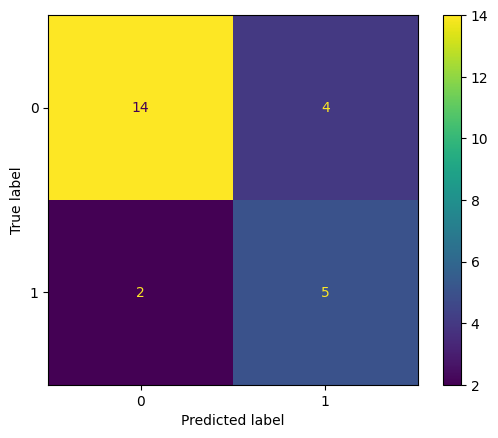

{'logreg__C': 0.2}

In [64]:
pipeline = Pipeline([
    ('log_transform', FunctionTransformer(np.log1p)),
    ('min_max_scale', MinMaxScaler()),
    ('logreg', LogisticRegression(random_state=42))
])
# define the hyperparameters to search over
param_grid = {
    'logreg__C': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
}

# perform grid search to find the best hyperparameters
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, n_jobs=-1)
# Fit the GridSearchCV object on the training data
grid_search.fit(X_train_resampled, y_train_resampled)
# Get the best estimator and make predictions on the testing data
best_estimator = grid_search.best_estimator_
y_pred = best_estimator.predict(X_test)

# Compute accuracy for the best found RF
report = classification_report(y_test, y_pred)
params = grid_search.best_params_
# print("Accuracy:", accuracy)
print(report)
print("Area under the curve", roc_auc_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=best_estimator.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=best_estimator.classes_)
disp.plot()
plt.show()
grid_search.best_params_

In [65]:
best_estimator = grid_search.best_estimator_
y_pred = best_estimator.predict(X_test)

# Compute accuracy for the best found RF
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).T
report_df.to_csv("baseline_classification_report.csv", sep=";")

## Random forest

Accuracy: 0.76
Best score: 0.7678062678062678
              precision    recall  f1-score   support

           0       0.80      0.89      0.84        18
           1       0.60      0.43      0.50         7

    accuracy                           0.76        25
   macro avg       0.70      0.66      0.67        25
weighted avg       0.74      0.76      0.75        25

Area under the curve 0.6587301587301587


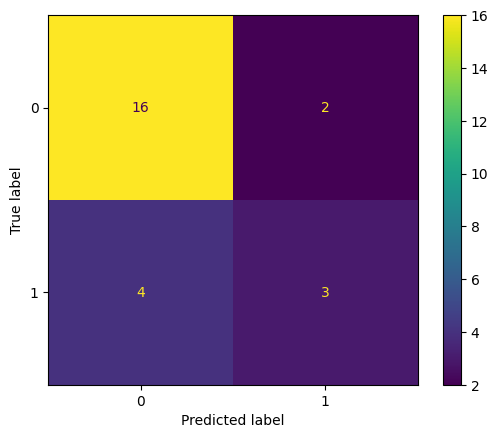

{'rf__criterion': 'gini',
 'rf__max_depth': 6,
 'rf__max_features': 'sqrt',
 'rf__n_estimators': 4}

In [66]:
# Define the Pipeline
rf_pipeline = Pipeline([
    ('log_transform', FunctionTransformer(np.log1p)),  # Step 1: log transformation
    ('rf', RandomForestClassifier(random_state=42, warm_start=True))  # Step 4: Random Forest
])
rf_param_grid = {
    # 'variance_filter__threshold': [0.1], # grid search value for variance filter threshold
    'rf__n_estimators': [1,2,3,4,5],  # Step 4: grid search for n_estimators
    'rf__max_depth': [1,2,3,4,5,6,7,8,9,10, None],  # Step 4: grid search for max_depth
    'rf__criterion' :['gini', 'entropy', 'log_loss'], # Step 4: grid search for criterion
    'rf__max_features': ['sqrt', 'log2'], # Step 4: grid search for number of max_features
}

# Define the GridSearchCV object
rf_grid_search = GridSearchCV(rf_pipeline, param_grid=rf_param_grid, cv=5, n_jobs=-1)

# Fit the GridSearchCV object on the training data
rf_grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best estimator and make predictions on the testing data
best_estimator = rf_grid_search.best_estimator_
y_pred = best_estimator.predict(X_test)

# Compute accuracy for the best found RF
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Best score:", rf_grid_search.best_score_)
# Compute accuracy for the best found RF
report = classification_report(y_test, y_pred)
# pd.DataFrame(report).T.to_csv("best_model_rf_classification_report.csv", sep=";")
params = rf_grid_search.best_params_
# print("Accuracy:", accuracy)
print(report)
print("Area under the curve", roc_auc_score(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred, labels=best_estimator.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=best_estimator.classes_)
disp.plot()
plt.show()
rf_grid_search.best_params_

In [67]:
f_imp = rf_grid_search.best_estimator_['rf'].feature_importances_
# print(f_imp)
rf_grid_search.best_estimator_.feature_names_in_[f_imp > 0.1]

array(['Phil1 sp001940855'], dtype=object)

<ErrorbarContainer object of 3 artists>

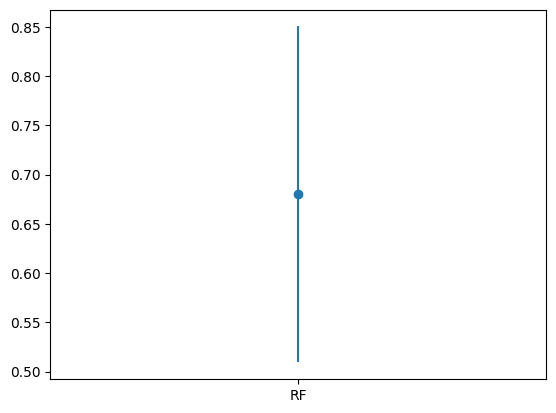

In [68]:
best_estimator = rf_grid_search.best_estimator_
scores = cross_val_score(best_estimator, X[selected_features], y, cv=20)
scores,scores.std(), scores.mean()
plt.errorbar(x=["RF"], y=[scores.mean()], yerr=[scores.std()], linestyle='None', marker='o')

## K-means clustering

In [286]:
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define the pipeline steps
steps = [
    ('log_transform', FunctionTransformer(np.log1p)),  # Step 1: log transformation
    ('kmeans', KMeans()),  # K-means clustering
    ('classifier', SVC())  # Classifier - Support Vector Machine
]

# Define the parameter grid for GridSearchCV
param_grid = {
    'kmeans__n_clusters': [2],  # Number of clusters for K-means
    'classifier__C': [0.1, 1, 10],  # Regularization parameter for SVM
    'classifier__kernel': ['linear', 'rbf']  # Kernel type for SVM
}

# Create the pipeline
pipeline = Pipeline(steps)

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5)

# Fit the pipeline with the data
grid_search.fit(X, y)  # X is your feature data, y is your target variable

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

In [290]:
best_estimator = rf_grid_search.best_estimator_
scores = cross_val_score(best_estimator, X, y, cv=10)
scores,scores.std(), scores.mean()
# plt.errorbar(x=["RF"], y=[scores.mean()], yerr=[scores.std()], linestyle='None', marker='o')

(array([0.38461538, 0.66666667, 0.58333333, 0.75      , 0.75      ,
        0.58333333, 0.83333333, 0.75      , 0.83333333, 0.75      ]),
 0.1311582950344526,
 0.6884615384615385)